In [ ]:
# Import necessary libraries

import pandas as pd
import os
import pandas as pd
import matplotlib.pyplot as plt
import chardet
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from torch.optim import AdamW
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from safetensors.torch import load_file
import torch.nn as nn
import torch.nn.functional as F
import math
import re
from sklearn.metrics import confusion_matrix
import os
import matplotlib.pyplot as plt
import seaborn as sns
from thop import profile
from thop import clever_format

In [ ]:
# Pastikan GPU tersedia jika ada
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
benign_folder = r"C:\Users\INFORMATIKA\Documents\Mahasiswa\Aditya\dataset\USTC-TFC2016\Benign"
malicious_folder = r"C:\Users\INFORMATIKA\Documents\Mahasiswa\Aditya\dataset\USTC-TFC2016\Malware"

In [ ]:
# Load benign data
benign_files = os.listdir(benign_folder)
benign_data = pd.concat([pd.read_csv(os.path.join(benign_folder, file), usecols=[ "Time", "Source", "Destination", "Protocol", "Length","Info"]) for file in benign_files])

# Load malicious data
malicious_files = os.listdir(malicious_folder)
malicious_data = pd.DataFrame()

In [ ]:
for file in malicious_files:
    filepath = os.path.join(malicious_folder, file)
    encoding = 'utf-8'  # Default encoding

    try:
        # Try reading the file with utf-8 encoding
        malicious_data = pd.concat([malicious_data, pd.read_csv(filepath, encoding=encoding, usecols=[ "Time", "Source", "Destination", "Protocol", "Length","Info"])])
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try detecting the encoding
        with open(filepath, 'rb') as f:
            result = chardet.detect(f.read())
        encoding = result['encoding']

        # Read CSV with detected encoding
        malicious_data = pd.concat([malicious_data, pd.read_csv(filepath, encoding=encoding, usecols=[ "Time", "Source", "Destination", "Protocol", "Length","Info"])])

In [ ]:
# Display the first few rows of the benign data
print("Benign Data:")
benign_data.head()

Benign Data:


,Time,Source,Destination,Protocol,Length,Info
0,0.000000,1.1.33.158,1.2.156.163,SSLv3,1475,Application Data
1,0.000002,1.1.23.218,1.2.31.193,SSLv3,163,Application Data
2,0.000004,1.2.84.77,1.1.252.248,TCP,70,443 > 22794 [ACK] Seq=1 Ack=1 Win=49232 Len=...
3,0.000004,1.1.71.180,1.2.79.35,SSLv3,1475,Application Data
4,0.000005,1.1.41.222,1.2.129.94,SSLv3,136,Application Data


In [ ]:
# Display the first few rows of the malicious data
print("Malicious Data:")
malicious_data.head()

Malicious Data:


,Time,Source,Destination,Protocol,Length,Info
0,0.000000,NaN,NaN,Ethernet,60,[Packet size limited during capture]
1,7.218304,PCSSystemtec_fb:bb:39,Broadcast,ARP,42,Who has 10.0.2.108? (ARP Probe)
2,7.218435,::,ff02::1:ff01:e8a5,ICMPv6,78,Neighbor Solicitation for fe80::705a:530f:1701...
3,7.218473,fe80::705a:530f:1701:e8a5,ff02::2,ICMPv6,70,Router Solicitation from 08:00:27:fb:bb:39
4,7.218524,fe80::705a:530f:1701:e8a5,ff02::16,ICMPv6,90,Multicast Listener Report Message v2


In [ ]:
malicious_data.shape

(2878927, 6)

In [ ]:
benign_data.shape

(3062079, 6)

In [ ]:
# Removing rows with ARP and DHCP protocol from benign dataset
benign_data = benign_data[(benign_data['Protocol'] != 'ARP') & (benign_data['Protocol'] != 'DHCP')]

# Removing rows with ARP and DHCP protocol from malicious dataset
malicious_data = malicious_data[(malicious_data['Protocol'] != 'ARP') & (malicious_data['Protocol'] != 'DHCP')]

In [ ]:
# Display the first few rows of the benign data
print("Benign Data:")
benign_data.head()

Benign Data:


,Time,Source,Destination,Protocol,Length,Info
0,0.000000,1.1.33.158,1.2.156.163,SSLv3,1475,Application Data
1,0.000002,1.1.23.218,1.2.31.193,SSLv3,163,Application Data
2,0.000004,1.2.84.77,1.1.252.248,TCP,70,443 > 22794 [ACK] Seq=1 Ack=1 Win=49232 Len=...
3,0.000004,1.1.71.180,1.2.79.35,SSLv3,1475,Application Data
4,0.000005,1.1.41.222,1.2.129.94,SSLv3,136,Application Data


In [ ]:
# Display the first few rows of the benign data
print("Malicious Data:")
malicious_data.head()

Malicious Data:


,Time,Source,Destination,Protocol,Length,Info
0,0.000000,NaN,NaN,Ethernet,60,[Packet size limited during capture]
2,7.218435,::,ff02::1:ff01:e8a5,ICMPv6,78,Neighbor Solicitation for fe80::705a:530f:1701...
3,7.218473,fe80::705a:530f:1701:e8a5,ff02::2,ICMPv6,70,Router Solicitation from 08:00:27:fb:bb:39
4,7.218524,fe80::705a:530f:1701:e8a5,ff02::16,ICMPv6,90,Multicast Listener Report Message v2
5,7.379151,fe80::705a:530f:1701:e8a5,ff02::1:2,DHCPv6,146,Solicit XID: 0xb5dec7 CID: 000100011751c322080...


In [ ]:
# Add a 'Class' column to each DataFrame
benign_data['Class'] = 0
malicious_data['Class'] = 1

# Concatenate the DataFrames
combined_data = pd.concat([benign_data, malicious_data], ignore_index=True)

In [ ]:
combined_data.shape

(5882184, 7)

In [ ]:
combined_data.head()

,Time,Source,Destination,Protocol,Length,Info,Class
0,0.000000,1.1.33.158,1.2.156.163,SSLv3,1475,Application Data,1
1,0.000002,1.1.23.218,1.2.31.193,SSLv3,163,Application Data,1
2,0.000004,1.2.84.77,1.1.252.248,TCP,70,443 > 22794 [ACK] Seq=1 Ack=1 Win=49232 Len=...,1
3,0.000004,1.1.71.180,1.2.79.35,SSLv3,1475,Application Data,1
4,0.000005,1.1.41.222,1.2.129.94,SSLv3,136,Application Data,1


In [ ]:
class_counts = combined_data['Class'].value_counts()
class_0_count = class_counts[0]
class_1_count = class_counts[1]

In [ ]:
class_1_count

2820105

In [ ]:
class_0_count

3062079

In [ ]:
# See value in class

print(combined_data['Class'].unique())

[1 0]


In [ ]:
# Check for missing values in the combined_data DataFrame
missing_values = combined_data.isnull().sum()
print(missing_values)

#Alternatively, to get a percentage of missing values
missing_percentage = (combined_data.isnull().sum() / len(combined_data)) * 100
missing_percentage

Time             0
Source           6
Destination      6
Protocol         0
Length           0
Info           693
Class            0
dtype: int64


Time           0.000000
Source         0.000102
Destination    0.000102
Protocol       0.000000
Length         0.000000
Info           0.011781
Class          0.000000
dtype: float64

In [ ]:
# Drop rows with any missing values
combined_data = combined_data.dropna()

# Verify if there are any missing values left
missing_values_after_drop = combined_data.isnull().sum()
print(missing_values_after_drop)

#Alternatively, to get a percentage of missing values after dropping
missing_percentage_after_drop = (combined_data.isnull().sum() / len(combined_data)) * 100
missing_percentage_after_drop

Time           0
Source         0
Destination    0
Protocol       0
Length         0
Info           0
Class          0
dtype: int64


Time           0.0
Source         0.0
Destination    0.0
Protocol       0.0
Length         0.0
Info           0.0
Class          0.0
dtype: float64

# **Transformer Applying**

In [ ]:
# Convert "Info" column to a list of strings
info_texts = combined_data["Info"].tolist()

In [ ]:
# Calculate the number of rows for the random half
random_half_size = math.ceil(len(combined_data) / 100)

# Randomly select a half from the DataFrame
random_half_data = combined_data.sample(n=random_half_size, random_state=42)

# Preprocess the "Info" column
preprocessed_texts = random_half_data["Info"].astype(str).apply(lambda x: re.sub(r"[^\w\s]", "", x).lower().strip())

# Convert preprocessed texts to a list of strings
info_texts = preprocessed_texts.tolist()

In [ ]:
random_half_data.shape

(58815, 7)

In [ ]:
class_counts_new = random_half_data['Class'].value_counts()
class_0_count_new = class_counts_new[0]
class_1_count_new = class_counts_new[1]

In [ ]:
class_0_count_new

28176

In [ ]:
class_1_count_new

30639

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize text and convert labels to numerical values
inputs = tokenizer.batch_encode_plus(
    info_texts,
    padding=True,
    truncation=True,
    return_tensors="pt"
)

In [ ]:
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]
labels = LabelEncoder().fit_transform(random_half_data["Class"])

# Step 6: Train/Test Split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    input_ids, labels, test_size=0.3, random_state=42
)
train_masks, test_masks, _, _ = train_test_split(
    attention_mask, input_ids, test_size=0.3, random_state=42
)

# Convert inputs, masks, and labels into PyTorch tensors
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
test_inputs = torch.tensor(test_inputs)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_masks)

# Create DataLoader for batch processing
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False)

C:\Users\INFORMATIKA\AppData\Local\Temp\ipykernel_3564\3711126622.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs)
C:\Users\INFORMATIKA\AppData\Local\Temp\ipykernel_3564\3711126622.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_masks = torch.tensor(train_masks)
C:\Users\INFORMATIKA\AppData\Local\Temp\ipykernel_3564\3711126622.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs = torch.tensor(test_inputs)
C:\Users\INFORMATIKA\AppData\Local\Temp\ipykernel_3564\3711126622

# **Load Transformer Model**

In [ ]:
# load config
config = BertConfig.from_pretrained(r"C:\Users\INFORMATIKA\Documents\Mahasiswa\Aditya\save_model\saved_model1")
tf_model = BertForSequenceClassification(config)

config.output_hidden_states = True

# Load Weights
state_dict = load_file(r"C:\Users\INFORMATIKA\Documents\Mahasiswa\Aditya\save_model\saved_model1\model.safetensors")
tf_model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# Freeze BERT
for param in tf_model.parameters():
    param.requires_grad = False

In [ ]:
# Membuat tabel summary dan parameter model
summary_data = []

# Tambahkan informasi summary
summary_data.append(["Model Name", "BERT"])
summary_data.append(["Tokenizer", str(type(tokenizer))])
summary_data.append(["config", str(type(config))])

# Tambahkan parameter model ke dalam tabel (contoh beberapa parameter)
for param_name, param in tf_model.named_parameters():
  summary_data.append([param_name, param.shape])


# Menampilkan tabel
html_table = "<table>"
for row in summary_data:
  html_table += "<tr>"
  for cell in row:
      html_table += f"<td>{cell}</td>"
  html_table += "</tr>"
html_table += "</table>"

display(HTML(html_table))

Model Name,BERT
Tokenizer,
config,
bert.embeddings.word_embeddings.weight,"torch.Size([30522, 768])"
bert.embeddings.position_embeddings.weight,"torch.Size([512, 768])"
bert.embeddings.token_type_embeddings.weight,"torch.Size([2, 768])"
bert.embeddings.LayerNorm.weight,torch.Size([768])
bert.embeddings.LayerNorm.bias,torch.Size([768])
bert.encoder.layer.0.attention.self.query.weight,"torch.Size([768, 768])"
bert.encoder.layer.0.attention.self.query.bias,torch.Size([768])
bert.encoder.layer.0.attention.self.key.weight,"torch.Size([768, 768])"


In [ ]:
layers = []
for name, param in tf_model.named_parameters():
    layers.append({
        "Layer Name": name,
        "Trainable": param.requires_grad,
        "Shape": tuple(param.shape),
        "Num Parameters": param.numel()
    })

df = pd.DataFrame(layers)
print(df)


                                       Layer Name  Trainable         Shape  \
0          bert.embeddings.word_embeddings.weight      False  (30522, 768)   
1      bert.embeddings.position_embeddings.weight      False    (512, 768)   
2    bert.embeddings.token_type_embeddings.weight      False      (2, 768)   
3                bert.embeddings.LayerNorm.weight      False        (768,)   
4                  bert.embeddings.LayerNorm.bias      False        (768,)   
..                                            ...        ...           ...   
196   bert.encoder.layer.11.output.LayerNorm.bias      False        (768,)   
197                      bert.pooler.dense.weight      False    (768, 768)   
198                        bert.pooler.dense.bias      False        (768,)   
199                             classifier.weight      False      (2, 768)   
200                               classifier.bias      False          (2,)   

     Num Parameters  
0          23440896  
1            393216

# **Transfer Learning for Trans Neural Network**

In [ ]:
# Print shapes to verify
print(f"train_inputs shape: {train_inputs.shape}")
print(f"train_labels shape: {train_labels.shape}")
print(f"train_masks shape: {train_masks.shape}")
print(f"test_inputs shape: {test_inputs.shape}")
print(f"test_labels shape: {test_labels.shape}")
print(f"test_masks shape: {test_masks.shape}")

train_inputs shape: torch.Size([41170, 210])
train_labels shape: torch.Size([41170])
train_masks shape: torch.Size([41170, 210])
test_inputs shape: torch.Size([17645, 210])
test_labels shape: torch.Size([17645])
test_masks shape: torch.Size([17645, 210])


In [ ]:
# Implementasi Feature Extractor untuk BERT
class FeatureExtractor(nn.Module):
    def __init__(self, tf_model):
        super(FeatureExtractor, self).__init__()
        self.tf_model = tf_model
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # Tidak ada gradient karena BERT dibekukan
            outputs = self.tf_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True
            )
            # Mendapatkan last hidden state (output dari transformer layer terakhir)
            last_hidden_state = outputs.hidden_states[-1]
            # Mendapatkan representasi token CLS (biasa digunakan untuk klasifikasi)
            cls_token = last_hidden_state[:, 0, :]
            # Mendapatkan output yang dipooling (dari bert.pooler)
            pooled_output = outputs.pooler_output


            return cls_token, pooled_output, last_hidden_state


In [ ]:
# Buat feature extractor dan uji dengan batch data
feature_extractor = FeatureExtractor(tf_model.bert)
feature_extractor.eval()  # Set ke mode evaluasi
feature_extractor = feature_extractor.to(device)

# Ambil satu batch dari dataloader untuk melihat bentuk tensor
batch = next(iter(train_dataloader))
batch_inputs, batch_masks, batch_labels = batch
batch_inputs = batch_inputs.to(device)
batch_masks = batch_masks.to(device)

with torch.no_grad():
    cls_features, pooled_features, sequence_features = feature_extractor(batch_inputs, batch_masks)

print(f"CLS features shape: {cls_features.shape}")
print(f"Pooled features shape: {pooled_features.shape}")
print(f"Sequence features shape: {sequence_features.shape}")


CLS features shape: torch.Size([16, 768])
Pooled features shape: torch.Size([16, 768])
Sequence features shape: torch.Size([16, 210, 768])


In [ ]:
# Implementasi Blok Residual untuk 1D CNN (ResNet)
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # Skip connection (identitas atau proyeksi)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Koneksi skip
        out = F.relu(out)
        return out

In [ ]:
class ResNet1D(nn.Module):
    def __init__(self, block, num_blocks, in_channels=64, hidden_dim=256, num_classes=2):
        super(ResNet1D, self).__init__()
        self.in_channels = in_channels

        # Konvolusi awal untuk memproses input
        self.conv1 = nn.Conv1d(1, in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(in_channels)

        # Layer ResNet
        self.layer1 = self._make_layer(block, in_channels, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, in_channels*2, num_blocks[1], stride=2)

        # Adaptive pooling untuk menangani panjang sekuens yang bervariasi
        self.avg_pool = nn.AdaptiveAvgPool1d(1)

        # Layer linear untuk klasifikasi
        self.fc = nn.Linear(in_channels*2, hidden_dim)
        self.dropout = nn.Dropout(0.2)  # Dropout untuk regularisasi
        self.bn_fc = nn.BatchNorm1d(hidden_dim)
        self.output = nn.Linear(hidden_dim, num_classes)

    def _make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, channels, stride))
            self.in_channels = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # Reshape untuk konvolusi 1D jika diperlukan
        batch_size = x.size(0)
        if len(x.shape) == 3:  # [batch_size, seq_len, hidden_dim]
            # Konversi ke [batch_size, 1, seq_len * hidden_dim] untuk konvolusi 1D
            x = x.reshape(batch_size, 1, -1)

        # Forward through ResNet
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)  # Flatten
        out = F.relu(self.fc(out))
        out = self.dropout(out)
        out = self.output(out)
        return out

In [ ]:
#  Implementasi Model Hybrid TNN (Transformer + CNN)
class TransNeuralNetwork(nn.Module):
    def __init__(self, tf_model, hidden_dim=768, num_classes=2):
        super(TransNeuralNetwork, self).__init__()
        # BERT Feature Extractor
        self.bert_feature_extractor = FeatureExtractor(tf_model)

        # Feature Fusion Layer
        self.fusion_layer = nn.Sequential(
            nn.Linear(768 * 2, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, hidden_dim)
        )

        # ResNet Component (ringan untuk efisiensi)
        self.resnet = ResNet1D(ResidualBlock1D, [2, 2], in_channels=64, hidden_dim=hidden_dim, num_classes=num_classes)

        # Layer klasifikasi akhir (opsional, karena ResNet sudah menghasilkan logits)
        self.classifier = nn.Linear(num_classes + hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        # Dapatkan fitur BERT
        cls_features, pooled_features, sequence_features = self.bert_feature_extractor(input_ids, attention_mask)

        # Feature Fusion - menggabungkan token CLS dan pooled output
        bert_features = torch.cat([cls_features, pooled_features], dim=1)
        fused_features = self.fusion_layer(bert_features)

        # Proses fitur sekuens dengan ResNet
        batch_size = sequence_features.size(0)
        seq_length = sequence_features.size(1)
        hidden_size = sequence_features.size(2)

        # Reshape untuk input ResNet
        resnet_input = sequence_features.reshape(batch_size, 1, seq_length * hidden_size)

        # Forward melalui ResNet
        resnet_output = self.resnet(resnet_input)

        # Gabungkan output untuk hasil akhir (opsional)
        final_output = torch.cat([resnet_output, fused_features], dim=1)
        # final_output = self.classifier(final_output)

        return resnet_output  # Atau gunakan final_output jika ingin menggabungkan


In [ ]:
# Buat model TNN
tnn_model = TransNeuralNetwork(tf_model.bert)
tnn_model = tnn_model.to(device)

# Cetak arsitektur model
print(tnn_model)

TransNeuralNetwork(
  (bert_feature_extractor): FeatureExtractor(
    (tf_model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, o

In [ ]:
# Implementasi perhitungan FLOPs
def count_flops(model, input_shape):
    # Buat dummy input
    input_ids = torch.zeros(1, input_shape[0][1], dtype=torch.long).to(device)
    attention_mask = torch.ones(1, input_shape[1][1]).to(device)

    flops, params = profile(model, inputs=(input_ids, attention_mask))
    flops, params = clever_format([flops, params], "%.3f")

    return flops, params

# Hitung FLOPs
batch = next(iter(train_dataloader))
batch_inputs, batch_masks, _ = batch
input_shape = (batch_inputs.shape, batch_masks.shape)
flops, params = count_flops(tnn_model, input_shape)

print(f"Model Complexity: {flops} FLOPs")
print(f"Model Parameters: {params}")

[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool1d'>.
Model Complexity: 40.770G FLOPs
Model Parameters: 88.342M


In [ ]:
# Fungsi Pelatihan
def train_tnn_model(model, train_dataloader, test_dataloader, num_epochs=35, learning_rate=2e-5):
    # Tentukan optimizer dan loss function
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    # Histori pelatihan
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'epoch_time': []
    }

    for epoch in range(num_epochs):
        # Catat waktu mulai epoch
        epoch_start_time = time.time()

        # Fase Training
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in train_dataloader:
            batch_inputs, batch_masks, batch_labels = batch
            batch_inputs = batch_inputs.to(device)
            batch_masks = batch_masks.to(device)
            batch_labels = batch_labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_inputs, batch_masks)
            loss = criterion(outputs, batch_labels)

            # Backward pass dan optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Hitung akurasi
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

        avg_train_loss = total_loss / len(train_dataloader)
        train_accuracy = correct / total

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_accuracy)

        # Fase Validasi
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in test_dataloader:
                batch_inputs, batch_masks, batch_labels = batch
                batch_inputs = batch_inputs.to(device)
                batch_masks = batch_masks.to(device)
                batch_labels = batch_labels.to(device)

                outputs = model(batch_inputs, batch_masks)
                loss = criterion(outputs, batch_labels)

                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_labels.size(0)
                val_correct += (predicted == batch_labels).sum().item()

        avg_val_loss = val_loss / len(test_dataloader)
        val_accuracy = val_correct / val_total

        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)

        # Hitung waktu epoch
        epoch_time = time.time() - epoch_start_time
        history['epoch_time'].append(epoch_time)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}, "
              f"Time: {epoch_time:.2f}s")

        scheduler.step()

    return model, history

In [ ]:
# Hyperparameters
num_epochs = 35
learning_rate = 2e-5

In [ ]:
# Latih model
print("Mulai pelatihan model TNN...")
trained_model, history = train_tnn_model(
    tnn_model,
    train_dataloader,
    test_dataloader,
    num_epochs=num_epochs,
    learning_rate=learning_rate
)

Mulai pelatihan model TNN...
Epoch [1/35], Train Loss: 0.0421, Train Acc: 0.9904, Val Loss: 0.0107, Val Acc: 0.9960, Time: 886.54s
Epoch [2/35], Train Loss: 0.0110, Train Acc: 0.9949, Val Loss: 0.0109, Val Acc: 0.9960, Time: 883.84s
Epoch [3/35], Train Loss: 0.0111, Train Acc: 0.9951, Val Loss: 0.0107, Val Acc: 0.9960, Time: 887.31s
Epoch [4/35], Train Loss: 0.0109, Train Acc: 0.9951, Val Loss: 0.0108, Val Acc: 0.9960, Time: 887.07s
Epoch [5/35], Train Loss: 0.0109, Train Acc: 0.9955, Val Loss: 0.0106, Val Acc: 0.9960, Time: 851.80s
Epoch [6/35], Train Loss: 0.0102, Train Acc: 0.9953, Val Loss: 0.0113, Val Acc: 0.9940, Time: 810.51s
Epoch [7/35], Train Loss: 0.0103, Train Acc: 0.9953, Val Loss: 0.0105, Val Acc: 0.9960, Time: 810.33s
Epoch [8/35], Train Loss: 0.0102, Train Acc: 0.9951, Val Loss: 0.0105, Val Acc: 0.9960, Time: 887.70s
Epoch [9/35], Train Loss: 0.0102, Train Acc: 0.9950, Val Loss: 0.0101, Val Acc: 0.9960, Time: 912.12s
Epoch [10/35], Train Loss: 0.0103, Train Acc: 0.9951,

In [ ]:
# Cell 11: Fungsi evaluasi model
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    # Catat waktu inferensi
    inference_times = []

    with torch.no_grad():
        for batch in dataloader:
            batch_inputs, batch_masks, batch_labels = batch
            batch_inputs = batch_inputs.to(device)
            batch_masks = batch_masks.to(device)

            # Catat waktu inferensi
            start_time = time.time()
            outputs = model(batch_inputs, batch_masks)
            end_time = time.time()
            inference_times.append(end_time - start_time)

            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    # Hitung metrik
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, output_dict=True)

    # Ekstrak metrik
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']

    # Buat confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Hitung waktu inferensi rata-rata
    avg_inference_time = sum(inference_times) / len(inference_times)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'classification_report': report,
        'inference_time': avg_inference_time,
        'inference_times': inference_times
    }

In [ ]:
# Evaluasi model
# Evaluasi pada test set
print("Evaluasi model...")
evaluation_results = evaluate_model(trained_model, test_dataloader)

# Cetak hasil evaluasi
print("\n========== Hasil Evaluasi Model TNN ==========")
print(f"Akurasi: {evaluation_results['accuracy']:.4f}")
print(f"Presisi: {evaluation_results['precision']:.4f}")
print(f"Recall: {evaluation_results['recall']:.4f}")
print(f"F1 Score: {evaluation_results['f1_score']:.4f}")
print(f"Waktu Inferensi Rata-rata: {evaluation_results['inference_time']*1000:.2f} ms per batch")
print(f"FLOPs: {flops}")
print(f"Jumlah Parameter: {params}")
print("===============================================")

Evaluasi model...

========== Hasil Evaluasi Model TNN ==========
Akurasi: 0.9957
Presisi: 0.9958
Recall: 0.9957
F1 Score: 0.9958
Waktu Inferensi Rata-rata: 11.86 ms per batch
FLOPs: 40.770G
Jumlah Parameter: 88.342M


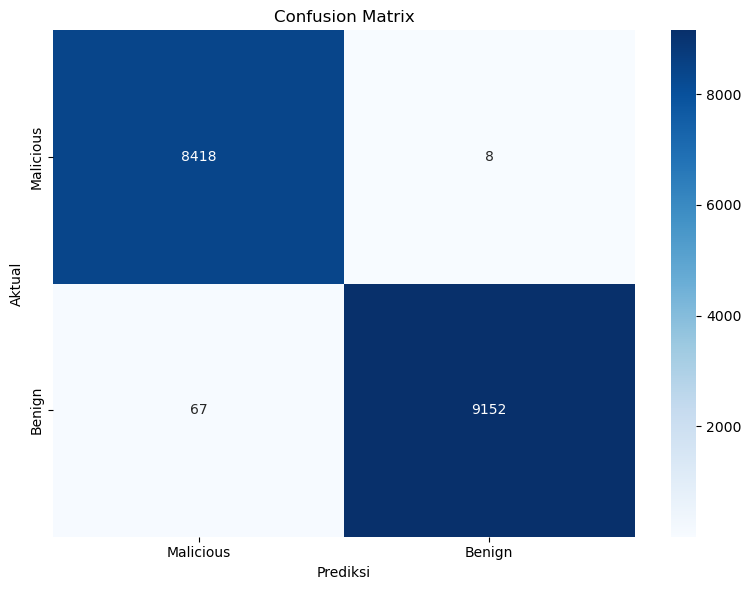

In [ ]:
# Cell 13: Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(evaluation_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Malicious', 'Benign'], yticklabels=['Malicious', 'Benign'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

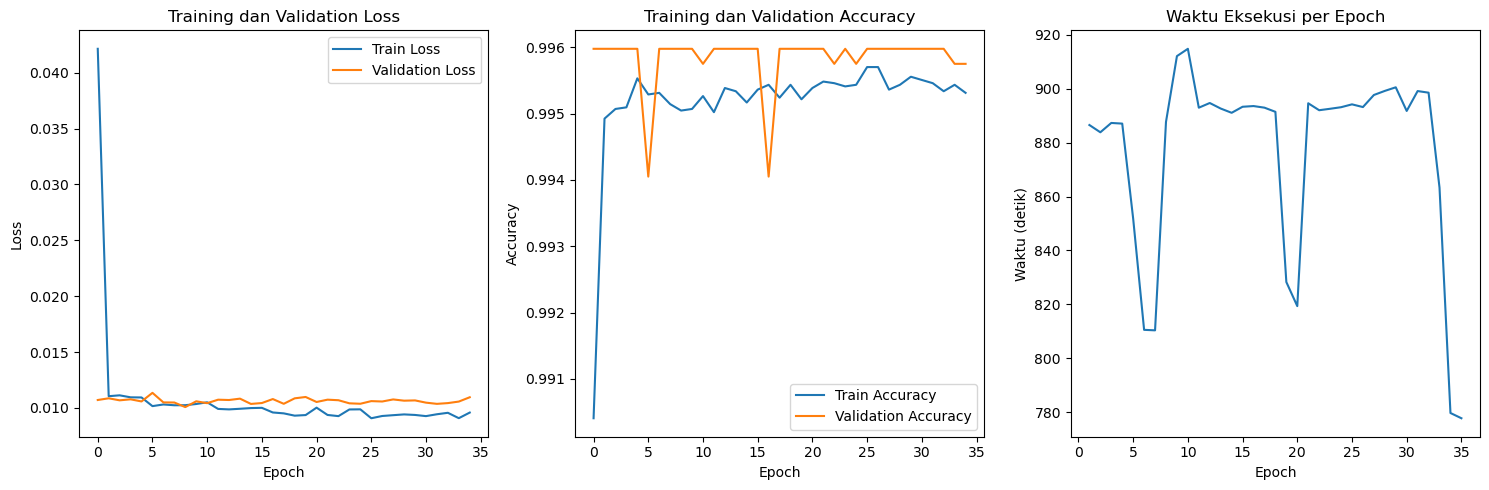

In [ ]:
# Cell 14: Visualisasi histori pelatihan
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training dan Validation Loss')

# Plot akurasi
plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training dan Validation Accuracy')

# Plot waktu epoch
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), history['epoch_time'])
plt.xlabel('Epoch')
plt.ylabel('Waktu (detik)')
plt.title('Waktu Eksekusi per Epoch')

plt.tight_layout()
plt.show()

In [ ]:
torch.save(trained_model.state_dict(), r'C:\Users\INFORMATIKA\Documents\Mahasiswa\Aditya\save_model\saved_model_ResNet_Improve/tnn_model_improve.pth')
print("Model TNN berhasil disimpan sebagai 'tnn_model_improve.pth'")

Model TNN berhasil disimpan sebagai 'tnn_model_improve.pth'


In [ ]:
# Cell 16: Tampilkan laporan klasifikasi lengkap
print("\n========== Laporan Klasifikasi Lengkap ==========")
for class_id, metrics in evaluation_results['classification_report'].items():
    if isinstance(metrics, dict):
        print(f"Kelas {class_id}: Presisi={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1={metrics['f1-score']:.4f}")
print("==================================================")


========== Laporan Klasifikasi Lengkap ==========
Kelas 0: Presisi=0.9921, Recall=0.9991, F1=0.9956
Kelas 1: Presisi=0.9991, Recall=0.9927, F1=0.9959
Kelas macro avg: Presisi=0.9956, Recall=0.9959, F1=0.9957
Kelas weighted avg: Presisi=0.9958, Recall=0.9957, F1=0.9958
